## CoastSat

This notebook is an adaptation of the scripts by K. Vos, available at https://github.com/kvos/CoastSat and https://github.com/SatelliteShorelines/SDS_Benchmark, where a detailed description of the method and implementation can be found.

This notebook calculates the satellite-derived beach width (BWsat) for six sites in Buenos Aires Province, Argentina, using shoreline data extracted with CoastSat and shore-normal transects. The workflow involves tidal corrections to standardize the BWsat values to mean sea level using FES2022 tidal data and MSAS sea level data, followed by wave setup corrections with data from the Wavery product to account for wave effects. Results are saved for further analysis.. 

Requirements:

    CoastSat: For extracting shoreline data. Download repository from https://github.com/kvos/CoastSat
    py_wave_runup: to compute wave setup. For more information see https://github.com/SatelliteShorelines/SDS_Benchmark
    

NOTE: This code loads the coastlines obtained with the locally trained image classifier model. If you want to load the coastlines with the CoastSat defoult model change 'shorelines_defoult_image_classificatio_model' for 'shorelines_local_image_classificatio_model' in dir_shorelines

In [1]:
# initial settings
%load_ext autoreload
%autoreload 2
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
import pickle
# beach slope estmation module
from coastsat import SDS_slope, SDS_transects, SDS_tools
import pandas as pd

In [2]:
# Define directories and load transects
base_dir = os.getcwd()  # Set the base directory as the current working directory

dir_shorelines = os.path.join(base_dir, 'SDS', 'shorelines_defoult_image_classificatio_model')  # Directory for shoreline data
dir_transects = os.path.join(base_dir, 'SDS', 'transects', 'transects.geojson')  # Path to transect GeoJSON file
dir_bw = os.path.join(base_dir, 'SDS', 'BWsat')  # Directory to save BW sat data
dir_tide = os.path.join(base_dir, 'Tide')  # Directory for tide data
dir_slope = os.path.join(base_dir, 'Slopes','slope_cs.csv')  # Directory for slope data

# List of site names and corresponding transect keys
sitename = ['Punta Raza', 'Mar del Tuyu', 'Mar de Ajo', 'Nueva Atlantis', 'Pinamar', 'Mar de las Pampas']
transect_keys = ['PR', 'MDT', 'MDA', 'NA', 'PI', 'MDP']

# Load transects from the GeoJSON file
loaded_transects = SDS_tools.transects_from_geojson(dir_transects)
transects = {key: value for key, value in zip(transect_keys, loaded_transects)}  # Create a dictionary of transects

#  Define parameters for computing intersections and removing outliers
settings_transects = { 
    'along_dist': 25,
    'min_points': 3,
    'max_std': 15,
    'max_range': 30,
    'min_chainage': -100,
    'multiple_inter': 'auto',
    'auto_prc': 0.1,
}


settings_outliers = {'max_cross_change':   40,             # maximum cross-shore change observable between consecutive timesteps
                     'otsu_threshold':     [-.5,0],        # min and max intensity threshold use for contouring the shoreline
                     'plot_fig':           True,           # whether to plot the intermediate steps
                    }


6 transects have been loaded coordinates are in epsg:32721


In [3]:
# Compute intersections
cross_distance = {}  # Create an empty dictionary to store beach widths (BW) for each transect
output_all = {}  # Initialize a dictionary to store all output data for each site

# Open and process output files for each site
for i, key in enumerate(transect_keys):
    site = sitename[i]  # Retrieve the site name based on index
    filepath = os.path.join(dir_shorelines, site)  # Define the file path for each site
    with open(os.path.join(filepath, site + '_output' + '.pkl'), 'rb') as f:
        output = pickle.load(f)  # Load output data from the pickle file
    output_all[key] = output  # Save the loaded output data in output_all under the current key
    
    # Get transects corresponding to the current key from the dictionary
    site_transects = loaded_transects[transect_keys[i]]

    # Create a dictionary for transects specific to the current site
    transects_dict = {transect_keys[i]: site_transects}
    
    # Compute intersections using the provided settings
    cross_distance1 = SDS_transects.compute_intersection_QC(output, transects_dict, settings_transects)
    
    # Store the result in cross_distance dictionary with the appropriate key
    cross_distance.update(cross_distance1)

# Store cross_distance dictionary

ruta_pickle_save = os.path.join(dir_bw, 'cross_distance.pkl')  # Define the file path to save the cross_distance data

# Save the cross_distance data as a pickle file
with open(ruta_pickle_save, 'wb') as f:
    pickle.dump(cross_distance, f)

print(f"File saved at: {ruta_pickle_save}")


File saved at: /Users/carolinbillet/Documents/Repositorio paper/SDS/BWsat/cross_distance.pkl


In [4]:
# Retain data within the temporal range defined by tide_msas availability
# Rounding dates and filtering

# Define the date range for analysis, setting to January 1, 1985 - December 31, 2021
settings_slope = {'date_range': [1985, 2021]}
settings_slope['date_range'] = [pytz.utc.localize(datetime(settings_slope['date_range'][0], 1, 1)),
                                pytz.utc.localize(datetime(settings_slope['date_range'][1], 12, 31))]

# Initialize dictionaries to store filtered data for each transect key
output_all_filtered = {}
cross_distance_filtered = {}
dates_sat = {}
satname_all = {}

# Iterate over each transect key to filter data within the specified date range
for key in transect_keys:
    output = output_all[key]
    
    # Round dates to the nearest hour to ensure consistency
    output['dates'] = pd.to_datetime(output['dates']).round("H")

    # Identify indices where dates fall within the specified date range
    idx_dates = [np.logical_and(date > settings_slope['date_range'][0], date < settings_slope['date_range'][1]) for date in output['dates']]
    filtered_indices = np.where(idx_dates)[0]
    
    # Store filtered dates for the current transect
    dates_sat[key] = np.array([output['dates'][i] for i in filtered_indices])
    
    # Store filtered satellite names associated with each date
    satname_all[key] = [output['satname'][i] for i in filtered_indices]
    
    # Filter cross_distance data for the same period
    cross_distance_site = {k: v[filtered_indices] for k, v in cross_distance.items() if k == key}
    cross_distance_filtered.update(cross_distance_site)

    # Filter output data for the same period
    output_site = {k: [v[i] for i in filtered_indices] for k, v in output.items()}
    output_all_filtered[key] = output_site



# Load the slopes obtained by CS.slope in the code 2.cs_slope.ipynb

In [5]:
slopes_cs = pd.read_csv(dir_slope) #load slopes compute with CS.slope
slopes_cs["name"]=cross_distance.keys()
slopes=slopes_cs.set_index('name')['slope'].to_dict()  #create dictionary 

# Tidal correction with data from model FES2022

In [6]:
# Define the full path to load the CSV file containing tide data
dir_tide_fes = os.path.join(dir_tide, 'tide_fes2022.csv')

# Load the CSV file into a pandas DataFrame
tide_fes = pd.read_csv(dir_tide_fes)

# Convert the 'dates' column to datetime format with UTC timezone
tide_fes['dates'] = pd.to_datetime(tide_fes['dates'], utc=True)

# Drop the unnamed column that was automatically added by pandas
tide_fes = tide_fes.drop(["Unnamed: 0"], axis=1)

# Initialize a dictionary to store tide data for each key in cross_distance_filtered
tide_sat = dict()

# Iterate through each key in the filtered cross_distance dictionary
for key in cross_distance_filtered.keys():
    # Create a DataFrame containing the specific dates for the current key
    df_key_dates = pd.DataFrame({'dates': dates_sat[key]})
    
    # Merge the tide_fes DataFrame with the key-specific dates to obtain the corresponding tide values
    df_tide_fes_key = pd.merge(df_key_dates, tide_fes[['dates', key]], on='dates', how='inner')
    
    # Store the tide_fes values corresponding to the current key in the tide_sat dictionary
    tide_sat[key] = df_tide_fes_key[key].to_numpy()

# Verify the dimensions of the cross_distance and tide_sat data for each key
for key in tide_sat:
    print(f"{key} - cross_distance: {cross_distance_filtered[key].shape} , tide_sat: {tide_sat[key].shape}")

# Create a copy of the tide_sat dictionary to tide_sat_fes
tide_sat_fes = tide_sat.copy()


PR - cross_distance: (1222,) , tide_sat: (1222,)
MDT - cross_distance: (1194,) , tide_sat: (1194,)
MDA - cross_distance: (1348,) , tide_sat: (1348,)
NA - cross_distance: (1252,) , tide_sat: (1252,)
PI - cross_distance: (1281,) , tide_sat: (1281,)
MDP - cross_distance: (1306,) , tide_sat: (1306,)


In [7]:
#Apply tide correction


# Retrieve the keys from the filtered cross_distance dictionary
cross_distance_keys = cross_distance_filtered.keys()

# Initialize a dictionary to store the tidally corrected cross distances
cross_distance_tidally_corrected_fes = {}

# Iterate over each key in the cross_distance_keys
for key in cross_distance_keys:
    # Get the filtered cross distance values for the current key
    bw = cross_distance_filtered[key]
    
    # Get the tide values corresponding to the current key from tide_sat_fes
    tide = tide_sat_fes[key]
    
    # Get the beach slope for the current key
    beach_slope = slopes[key]
    
    # Calculate the correction factor by dividing tide values by beach slope
    correction = tide / beach_slope
    
    # Store the corrected cross distance in the dictionary by adding the original values and the correction
    cross_distance_tidally_corrected_fes[key] = bw + correction


*PR  - outliers removed: 45
MDT  - outliers removed: 23
MDA  - outliers removed: 14
NA  - outliers removed: 26
PI  - outliers removed: 58
MDP  - outliers removed: 49


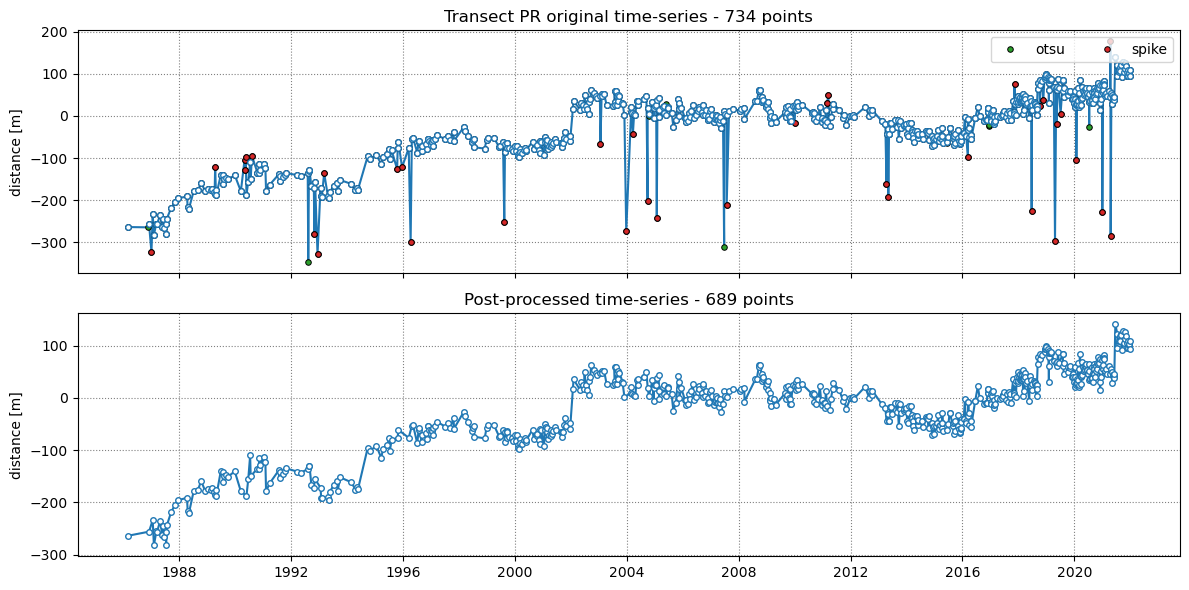

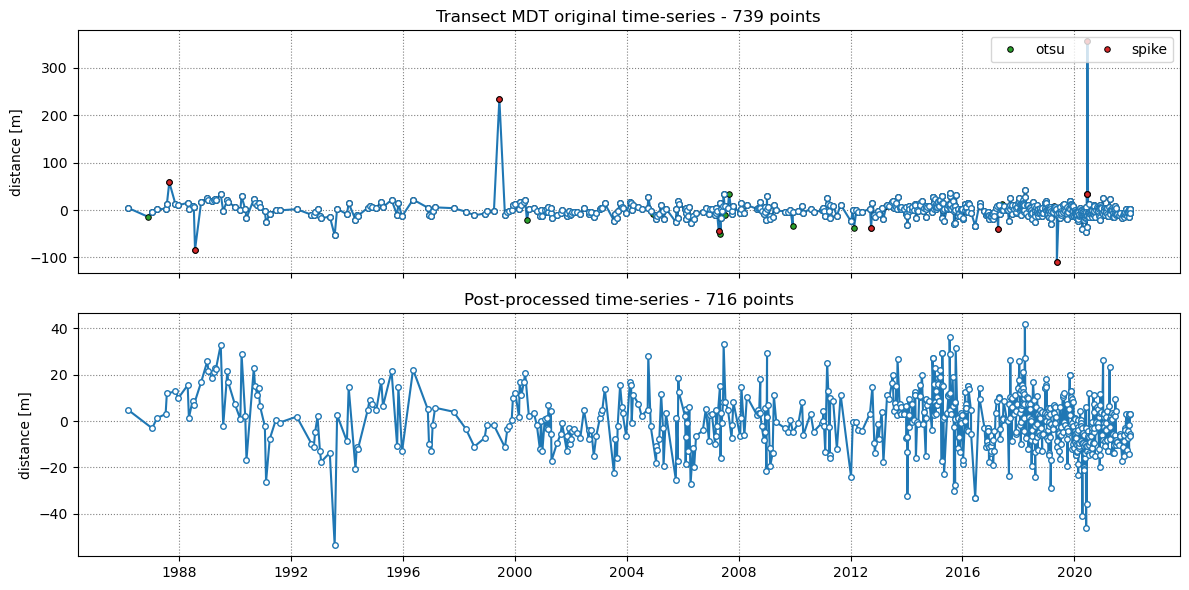

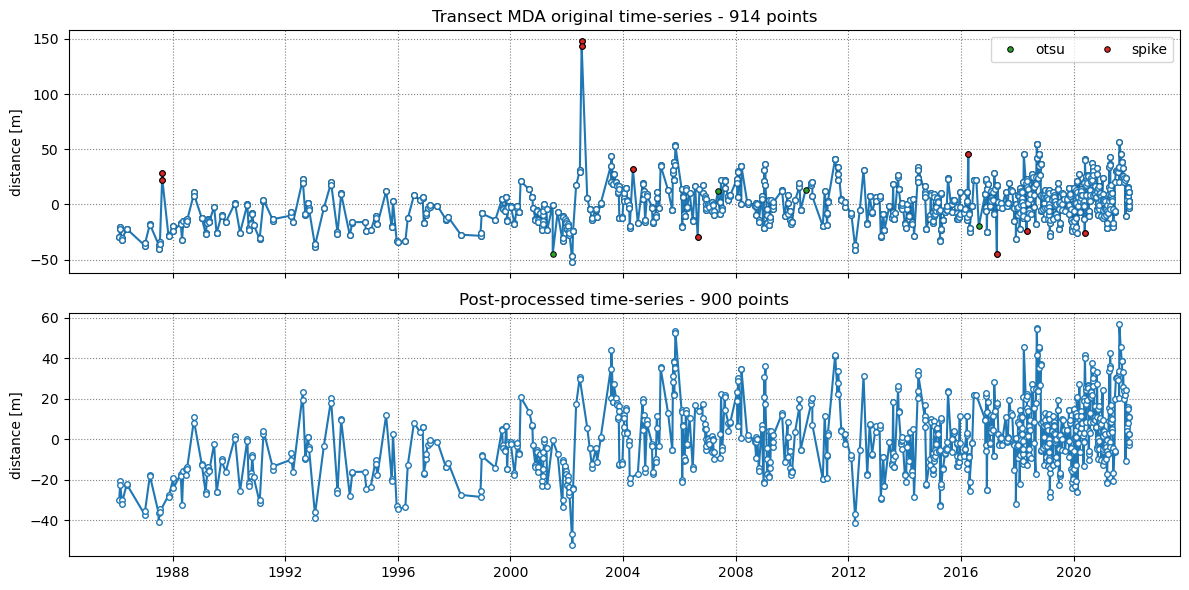

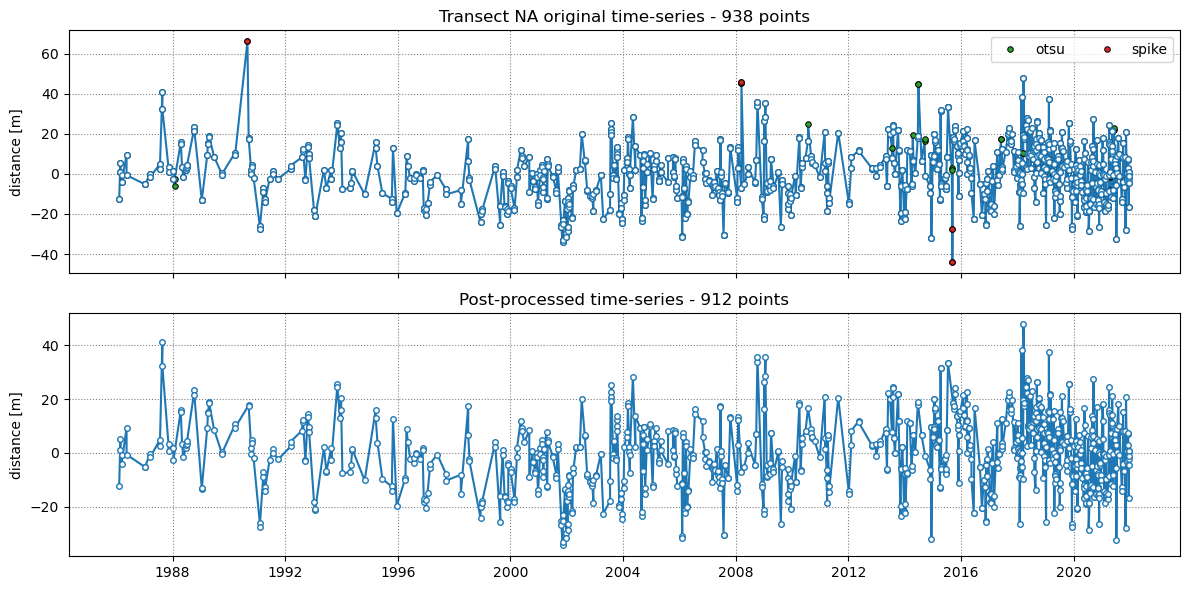

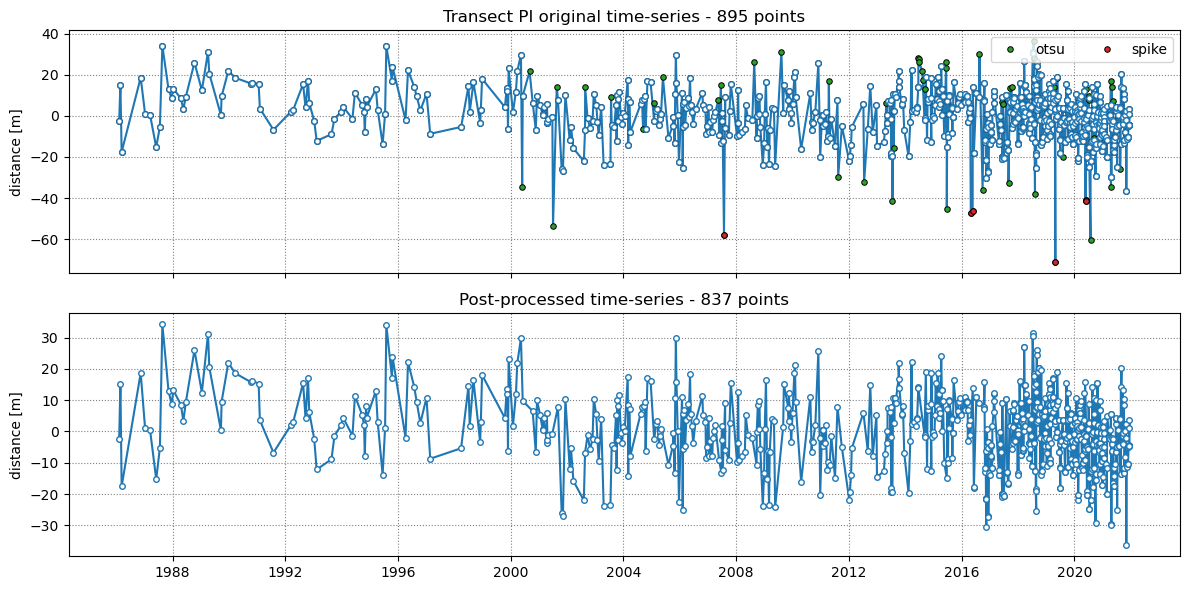

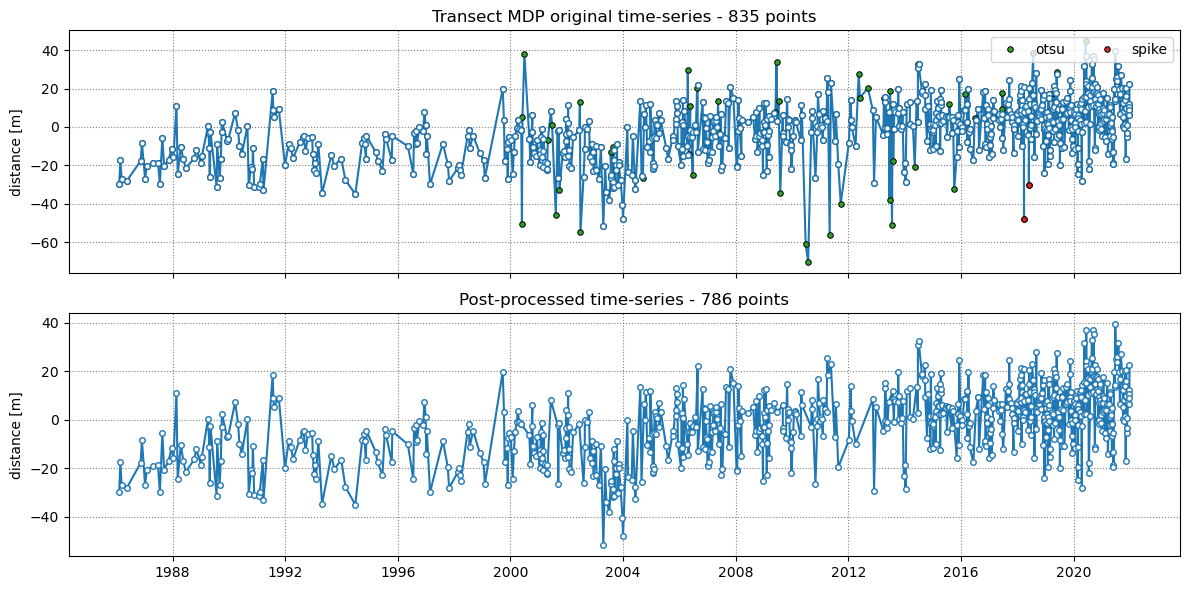

In [8]:
#remove outliers
cross_distance_final_fes = {}    
    
for i, key in enumerate(transect_keys):
    cross_distance_fes = cross_distance_tidally_corrected_fes[key]
    cross_distance_fes_dict = {transect_keys[i]: cross_distance_fes}
    output = output_all_filtered[key]
    
    cross_distance_final_fes1 = SDS_transects.reject_outliers( cross_distance_fes_dict, output, settings_outliers)
    cross_distance_final_fes.update(cross_distance_final_fes1)

In [9]:
#save BWsat tidaly corrected with FES2022 model
ruta_pickle = os.path.join(dir_bw, 'cross_distance_tidally_corrected_fes.pkl')
with open(ruta_pickle, 'wb') as f:
    pickle.dump(cross_distance_final_fes, f)

# Tidal correction with data from model MSAS

In [10]:
# Load and process the tide_msas data
ruta_csv = os.path.join(dir_tide, 'tide_msas.csv')  # Define the path to the CSV file
tide_msas = pd.read_csv(ruta_csv)  # Read the CSV file into a DataFrame
tide_msas['time'] = pd.to_datetime(tide_msas['time'], utc=True)  # Convert the 'time' column to datetime format with UTC timezone
tide_msas.columns = ["dates", 'PR', 'MDT', 'MDA', 'NA', 'PI', 'MDP']  # Rename the columns for easier access

# Initialize a dictionary to store tide values for each key
tide_sat = dict()

# Iterate over each key in the filtered cross_distance dictionary
for key in cross_distance_filtered.keys():
    # Create a DataFrame with dates specific to the current key
    df_key_dates = pd.DataFrame({'dates': dates_sat[key]})
    
    # Merge the tide_msas DataFrame with the key dates DataFrame to get tide values for the specific dates
    df_tide_msas_key = pd.merge(df_key_dates, tide_msas[['dates', key]], on='dates', how='left')
    
    # Store the tide_msas values corresponding to the current key in the dictionary
    tide_sat[key] = df_tide_msas_key[key].to_numpy()

# Verification of dimensions for each key in tide_sat
for key in tide_sat:
    print(f"{key} - dates: {cross_distance_filtered[key].shape}, tide_sat: {tide_sat[key].shape}")

# Create a copy of the tide_sat dictionary for tide_msas
tide_sat_msas = tide_sat.copy()


PR - dates: (1222,), tide_sat: (1222,)
MDT - dates: (1194,), tide_sat: (1194,)
MDA - dates: (1348,), tide_sat: (1348,)
NA - dates: (1252,), tide_sat: (1252,)
PI - dates: (1281,), tide_sat: (1281,)
MDP - dates: (1306,), tide_sat: (1306,)


In [11]:
#Apply tide correction
cross_distance_tidally_corrected_msas = {}
for key in cross_distance_keys:
    ap=cross_distance_filtered[key]
    tide=tide_sat_msas[key]
    date=dates_sat[key]
    beach_slope= slopes[key]   
    correction =tide/beach_slope
    cross_distance_tidally_corrected_msas[key] = ap + correction 

PR  - outliers removed: 41
MDT  - outliers removed: 22
MDA  - outliers removed: 9
NA  - outliers removed: 22
PI  - outliers removed: 51
MDP  - outliers removed: 46


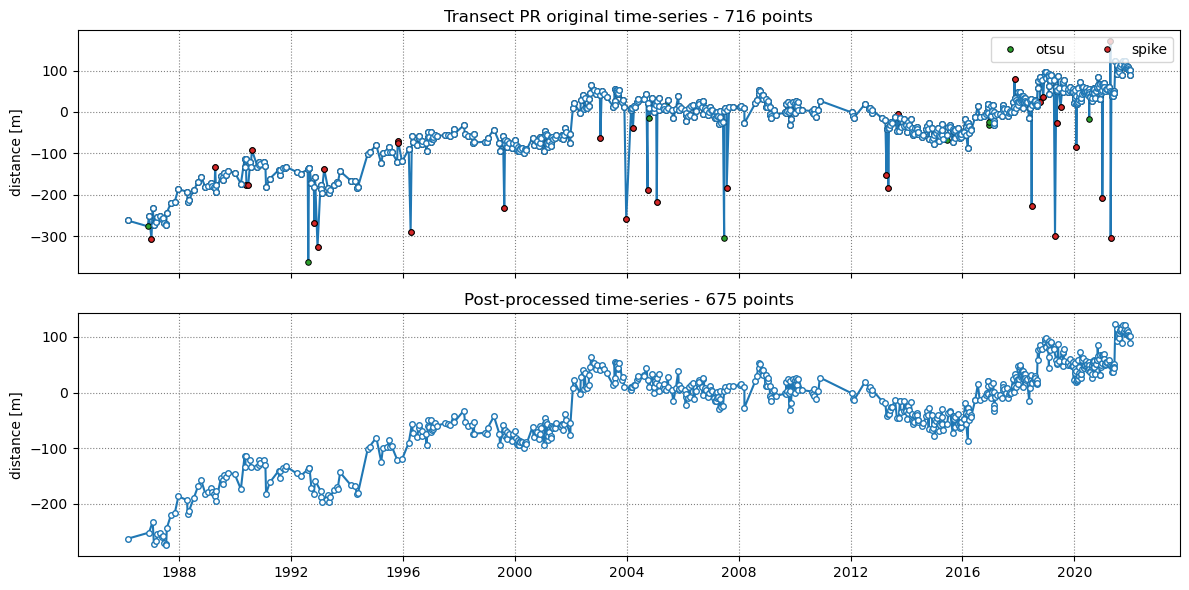

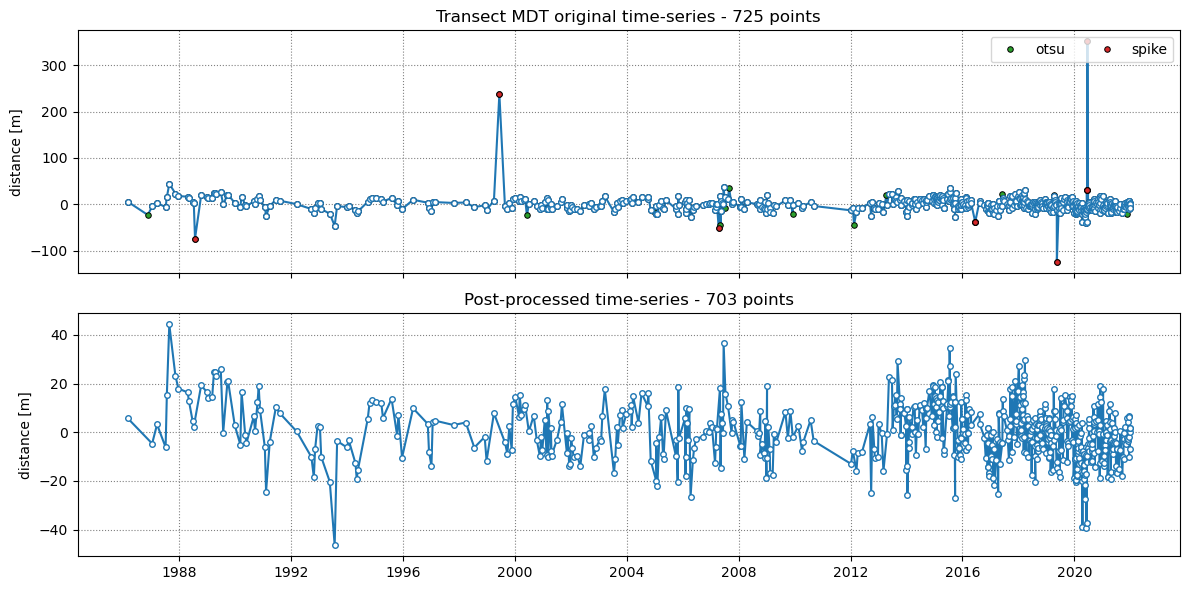

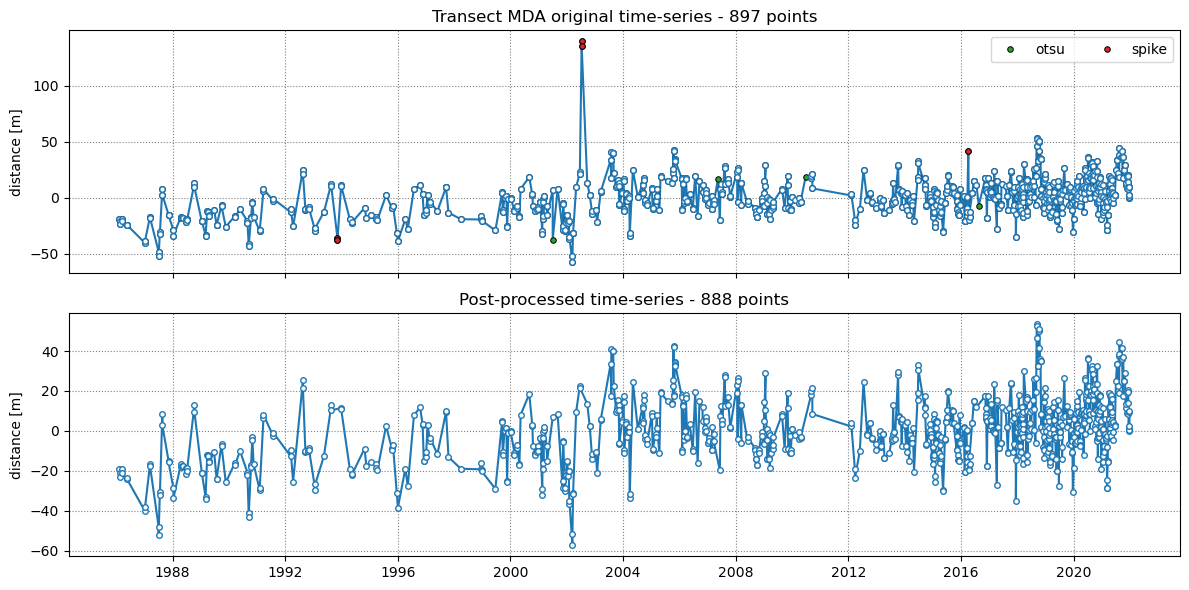

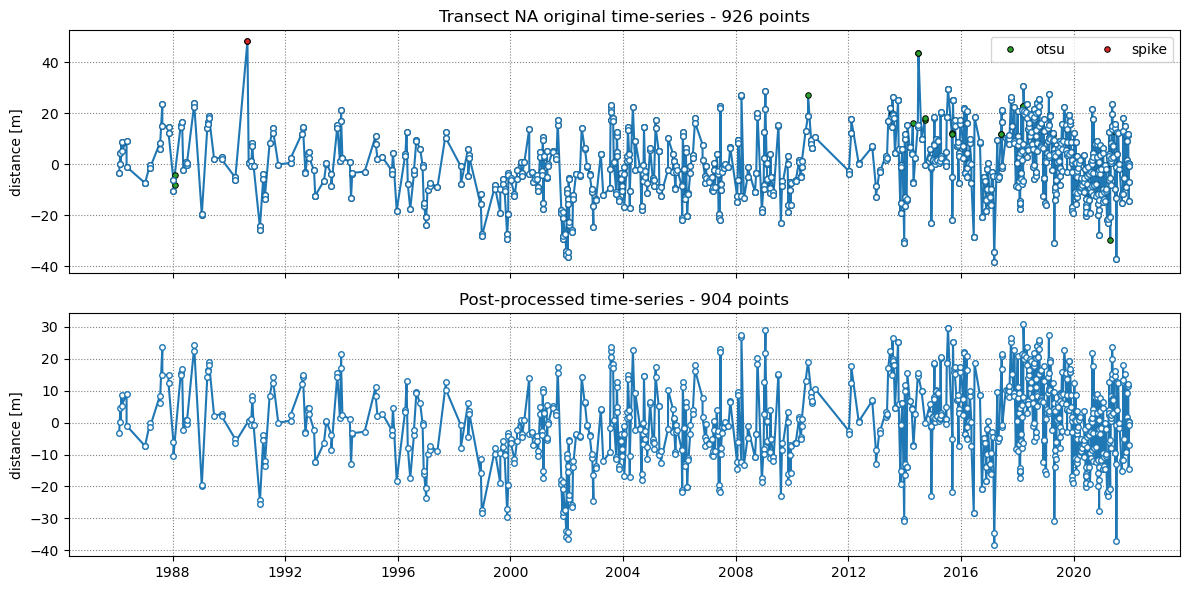

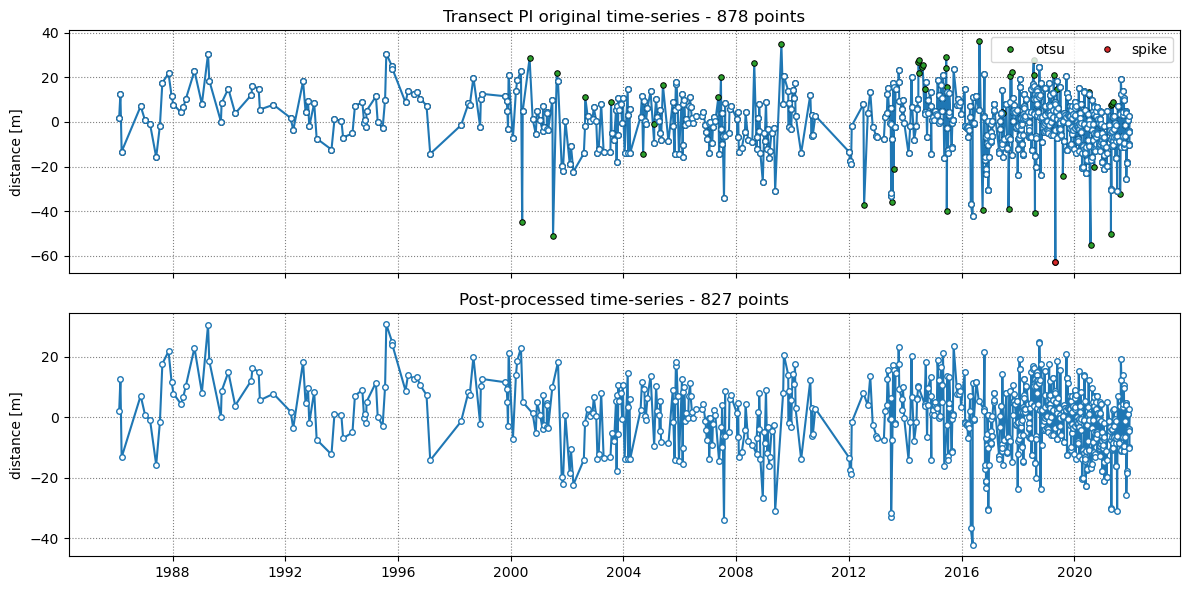

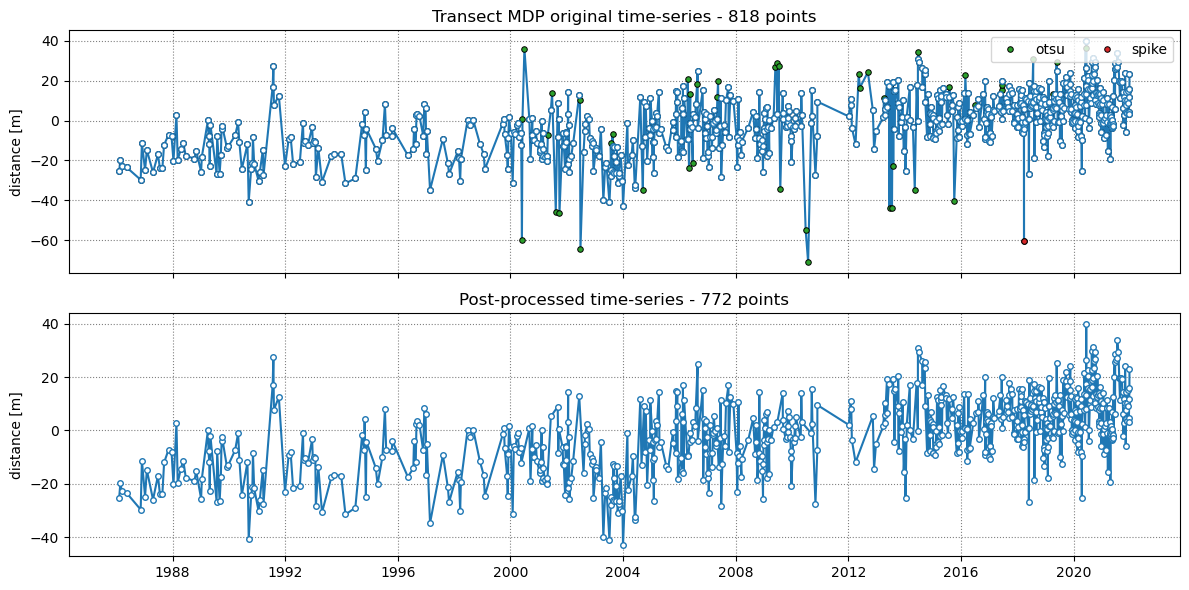

In [12]:
#remove outliers
cross_distance_final_msas = {}    
    
for i, key in enumerate(transect_keys):
    cross_distance_msas = cross_distance_tidally_corrected_msas[key]
    cross_distance_msas_dict = {transect_keys[i]: cross_distance_msas}
    output = output_all_filtered[key]
    
    cross_distance_final_msas1 = SDS_transects.reject_outliers( cross_distance_msas_dict, output, settings_outliers)
    cross_distance_final_msas.update(cross_distance_final_msas1)

In [13]:
#save BWsat tidaly corrected with MSAS model
ruta_pickle = os.path.join(dir_bw, 'cross_distance_tidally_corrected_msas.pkl')
with open(ruta_pickle, 'wb') as f:
    pickle.dump(cross_distance_final_msas, f)

# FES2022 + Wave Setup correction

In [14]:
from py_wave_runup import models
dir_waves=os.path.join(base_dir, 'WindWaves')
ruta_pickle = os.path.join(dir_waves, 'wind_waves.pkl')
with open(ruta_pickle, 'rb') as f:
    waves=pickle.load(f)
    
ruta_pickle = os.path.join(dir_waves, 'wind_waves_dates.pkl')
with open(ruta_pickle, 'rb') as f:
    dates_waves=pickle.load(f)
    
dates_waves= pd.to_datetime(dates_waves,utc=True)

In [15]:
# Create a dictionary to store wave data for each key (waves_sat)
waves_sat = dict()

# Convert dates_waves to a DataFrame and ensure that 'dates' is in datetime format
df_dates_waves = pd.DataFrame({'dates': pd.to_datetime(dates_waves)})

# Iterate over each key in dates_sat
for key in dates_sat.keys():
    # Convert dates_sat[key] to a DataFrame and ensure that 'dates' is in datetime format
    df_key_dates = pd.DataFrame({'dates': pd.to_datetime(dates_sat[key])})

    # Create a DataFrame for each wave variable in waves[key]
    df_waves_key = pd.DataFrame()
    for var_key in waves[key].keys():
        df_waves_key[var_key] = waves[key][var_key]

    # Add the 'dates' column to the wave DataFrame
    df_waves_key['dates'] = df_dates_waves['dates']

    # Sort both DataFrames by 'dates' to prepare for merge_asof
    df_key_dates = df_key_dates.sort_values('dates')
    df_waves_key = df_waves_key.sort_values('dates')

    # Perform an asof merge to get the closest wave data to the satellite dates
    df_waves_key_merged = pd.merge_asof(df_key_dates, df_waves_key, on='dates', direction='nearest')

    # Store the merged wave data in the dictionary for the current key
    waves_sat[key] = {var_key: df_waves_key_merged[var_key].to_numpy() for var_key in waves[key].keys()}

# Verify the dimensions of the wave data for each key and variable
for key in waves_sat:
    for var_key in waves_sat[key]:
        print(f"{key} - variable: {var_key}, shape: {waves_sat[key][var_key].shape}")

# Now, waves_sat contains the wave data corresponding to the nearest satellite dates for each key


PR - variable: VHM0, shape: (1222,)
PR - variable: VMDR, shape: (1222,)
PR - variable: VTPK, shape: (1222,)
MDT - variable: VHM0, shape: (1194,)
MDT - variable: VMDR, shape: (1194,)
MDT - variable: VTPK, shape: (1194,)
MDA - variable: VHM0, shape: (1348,)
MDA - variable: VMDR, shape: (1348,)
MDA - variable: VTPK, shape: (1348,)
NA - variable: VHM0, shape: (1252,)
NA - variable: VMDR, shape: (1252,)
NA - variable: VTPK, shape: (1252,)
PI - variable: VHM0, shape: (1281,)
PI - variable: VMDR, shape: (1281,)
PI - variable: VTPK, shape: (1281,)
MDP - variable: VHM0, shape: (1306,)
MDP - variable: VMDR, shape: (1306,)
MDP - variable: VTPK, shape: (1306,)


In [16]:
# Initialize a dictionary to store the wave-corrected cross distances for the FES data
cross_distance_wave_corrected_fes = {}

keys=cross_distance.keys()
# Process data and calculate the Stockdon model
for idx, key in enumerate(keys):
    # Retrieve the tidally corrected cross distance for the current key
    ap = cross_distance_tidally_corrected_fes[key]

    # Iterate over the wave variables for the current key
    for ky in waves_sat[key].keys():
        # Convert wave data from lists to NumPy arrays, handling any string values
        waves_sat[key][ky] = list(waves_sat[key][ky])
        idx_str = np.where([isinstance(_, str) for _ in waves_sat[key][ky]])[0]
        for i in idx_str:
            # Convert string representations of wave heights to floats
            waves_sat[key][ky][i] = float(waves_sat[key][ky][i].split('[')[-1].split(']')[0])
        waves_sat[key][ky] = np.array(waves_sat[key][ky])
        beach_slope= slopes[key] 

        Hs = waves_sat[key]['VHM0']  # Significant wave height
        Tp = waves_sat[key]['VTPK']   # Peak wave period

        # Calculate the Stockdon model for wave setup
        model_sto06 = models.Stockdon2006(Hs=Hs, Tp=Tp,
                                          beta=beach_slope * np.ones(len(Hs)))

        # Extract the wave setup from the model
        w_sat = model_sto06.setup

        # Calculate the correction based on the wave setup and beach slope
        correction = w_sat / beach_slope
        # Update the wave-corrected cross distance for the current key
        cross_distance_wave_corrected_fes[key] = ap + correction


*PR  - outliers removed: 45
MDT  - outliers removed: 23
MDA  - outliers removed: 13
NA  - outliers removed: 28
PI  - outliers removed: 56
MDP  - outliers removed: 49


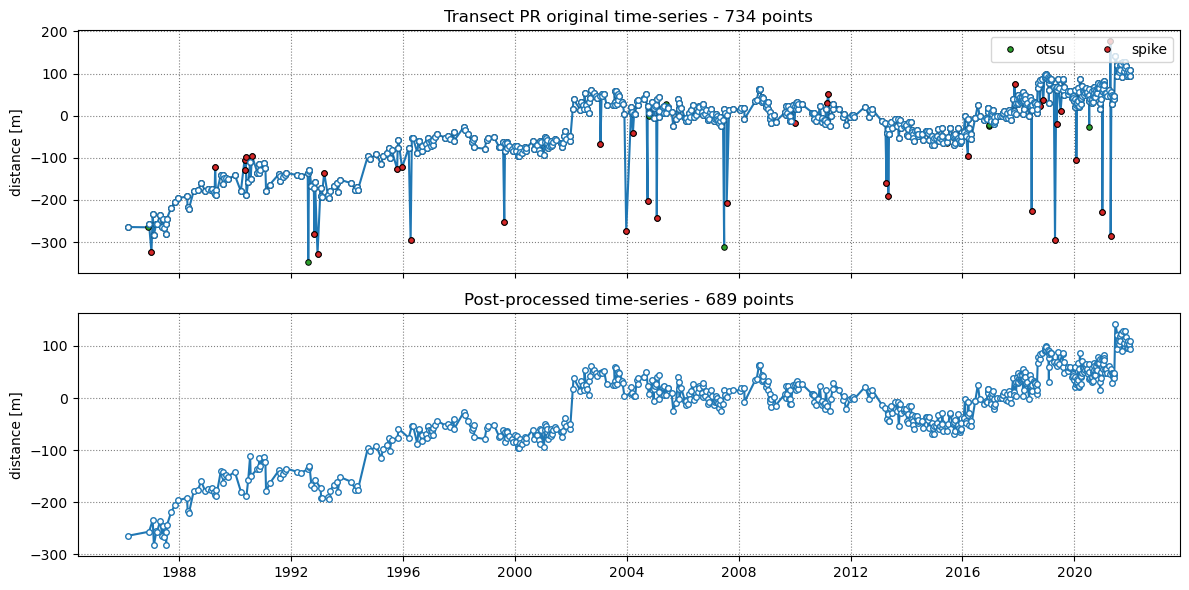

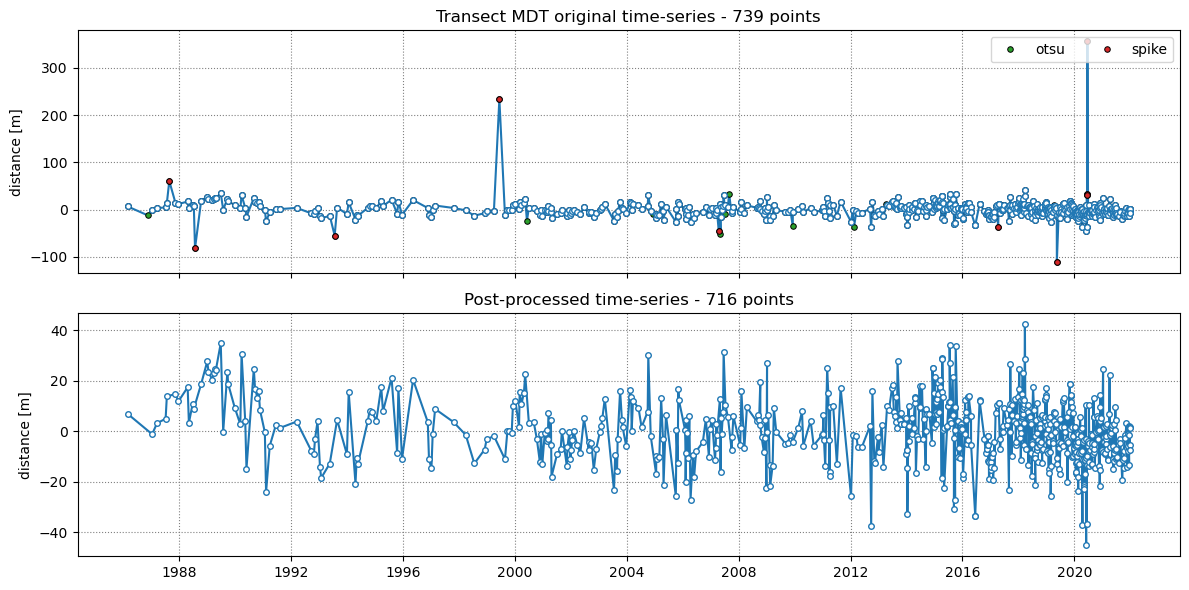

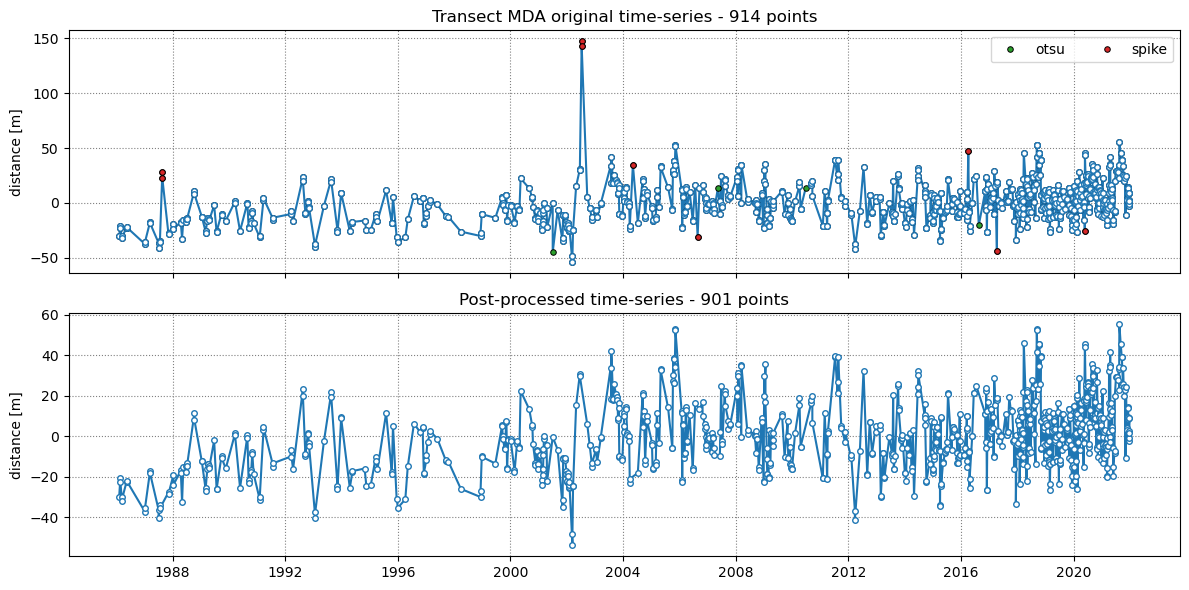

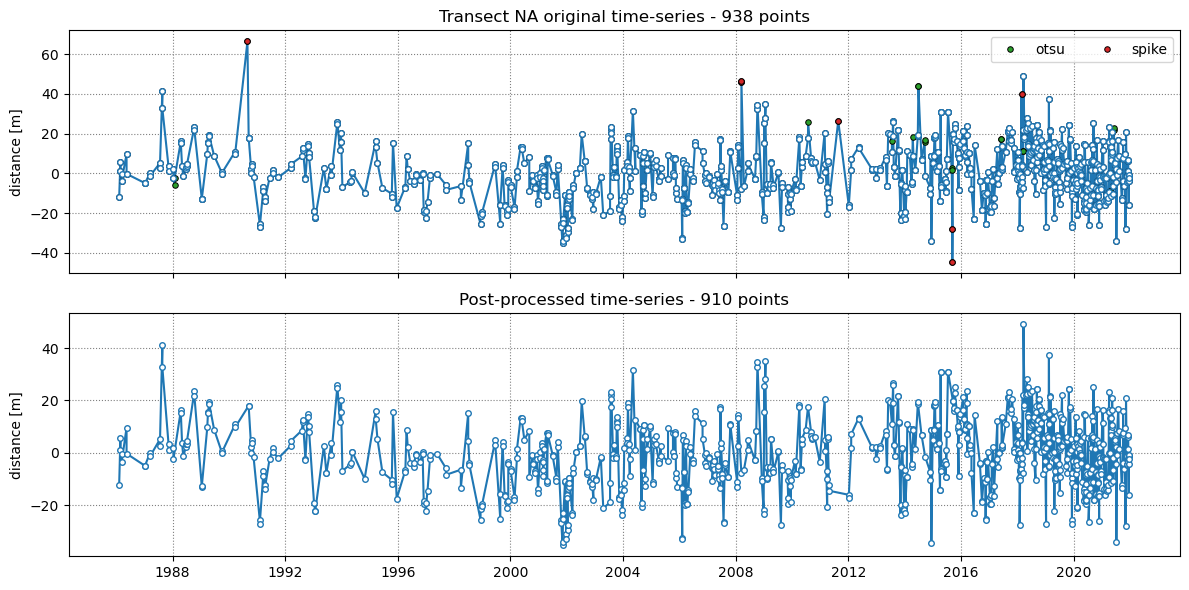

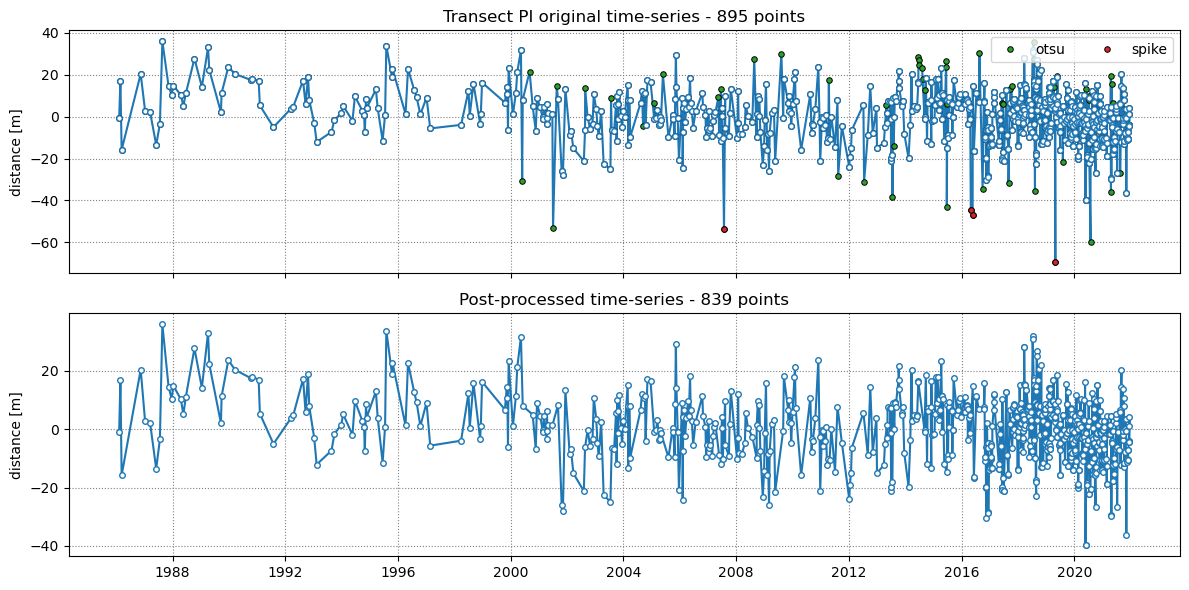

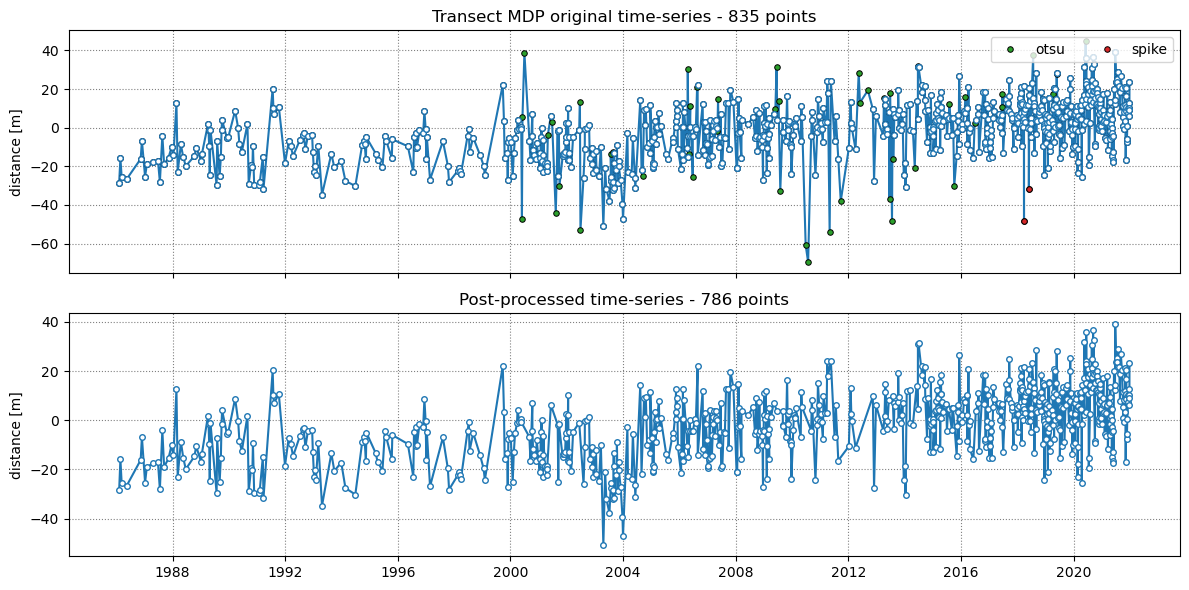

In [17]:
#remove outliers
cross_distance_final_fes_wave = {}    
    
for i, key in enumerate(transect_keys):
    cross_distance_fes = cross_distance_wave_corrected_fes[key]
    cross_distance_fes_dict = {transect_keys[i]: cross_distance_fes}
    output = output_all_filtered[key]
    
    cross_distance_final_fes1 = SDS_transects.reject_outliers( cross_distance_fes_dict, output, settings_outliers)
    cross_distance_final_fes_wave.update(cross_distance_final_fes1)

In [18]:
with open(os.path.join(dir_bw, 'cross_distance_tidally_corrected_fes_waves.pkl'), 'wb') as f:
    pickle.dump(cross_distance_final_fes_wave, f)

# MSAS + Wave Setup correction

In [19]:
# Initialize a dictionary to store the wave-corrected cross distances for the msas data
cross_distance_wave_corrected_msas = {}

keys=cross_distance.keys()
# Process data and calculate the Stockdon model
for idx, key in enumerate(keys):
    # Retrieve the tidally corrected cross distance for the current key
    ap = cross_distance_tidally_corrected_msas[key]

    # Iterate over the wave variables for the current key
    for ky in waves_sat[key].keys():
        # Convert wave data from lists to NumPy arrays, handling any string values
        waves_sat[key][ky] = list(waves_sat[key][ky])
        idx_str = np.where([isinstance(_, str) for _ in waves_sat[key][ky]])[0]
        for i in idx_str:
            # Convert string representations of wave heights to floats
            waves_sat[key][ky][i] = float(waves_sat[key][ky][i].split('[')[-1].split(']')[0])
        waves_sat[key][ky] = np.array(waves_sat[key][ky])
        beach_slope= slopes[key] 

        Hs = waves_sat[key]['VHM0']  # Significant wave height
        Tp = waves_sat[key]['VTPK']   # Peak wave period

        # Calculate the Stockdon model for wave setup
        model_sto06 = models.Stockdon2006(Hs=Hs, Tp=Tp,
                                          beta=beach_slope * np.ones(len(Hs)))

        # Extract the wave setup from the model
        w_sat = model_sto06.setup

        # Calculate the correction based on the wave setup and beach slope
        correction = w_sat / beach_slope
        # Update the wave-corrected cross distance for the current key
        cross_distance_wave_corrected_msas[key] = ap + correction


PR  - outliers removed: 40
MDT  - outliers removed: 20
MDA  - outliers removed: 9
NA  - outliers removed: 24
PI  - outliers removed: 51
MDP  - outliers removed: 46


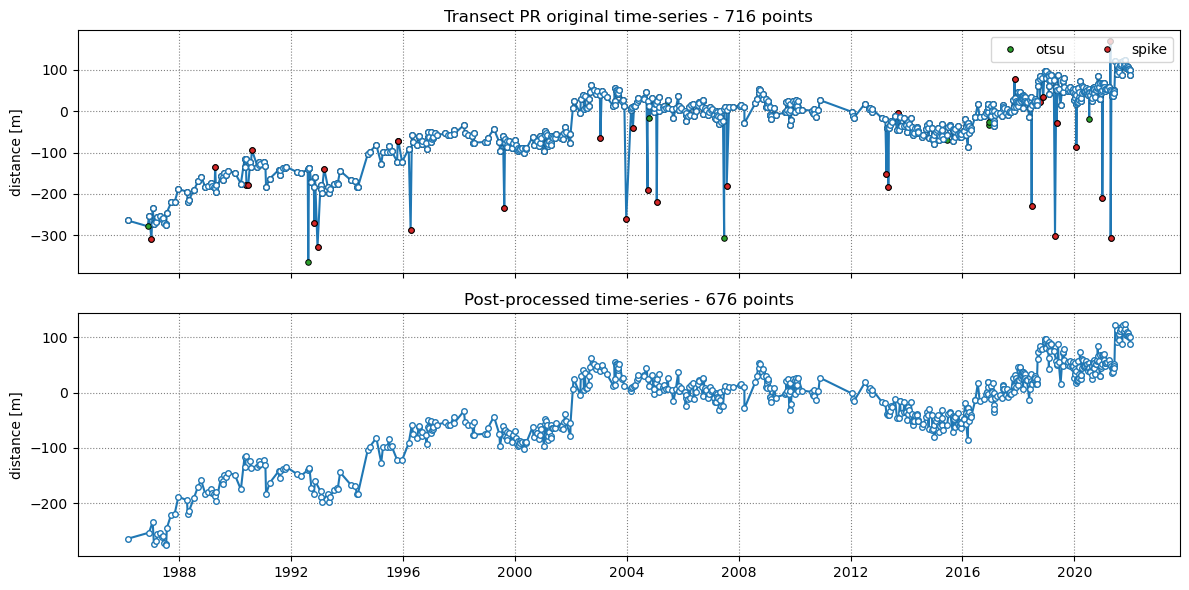

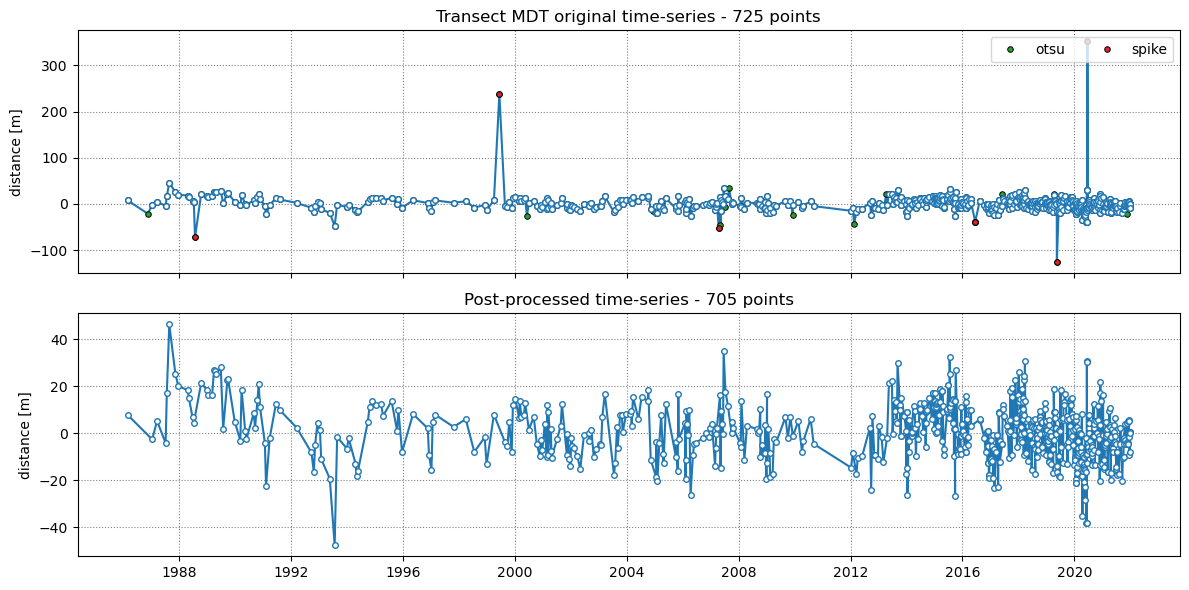

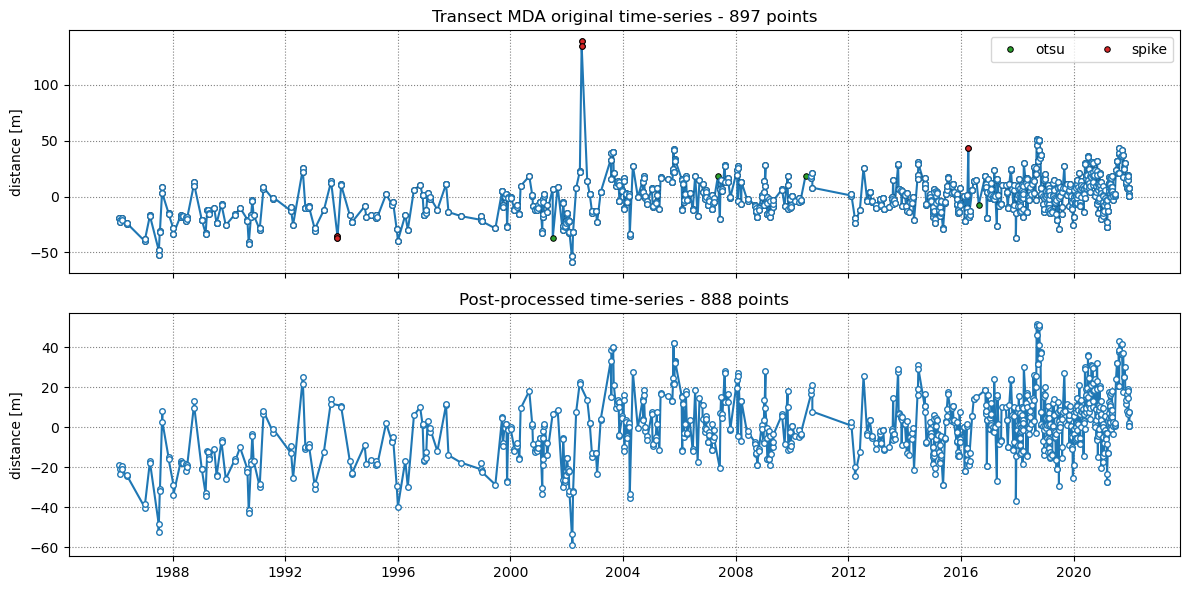

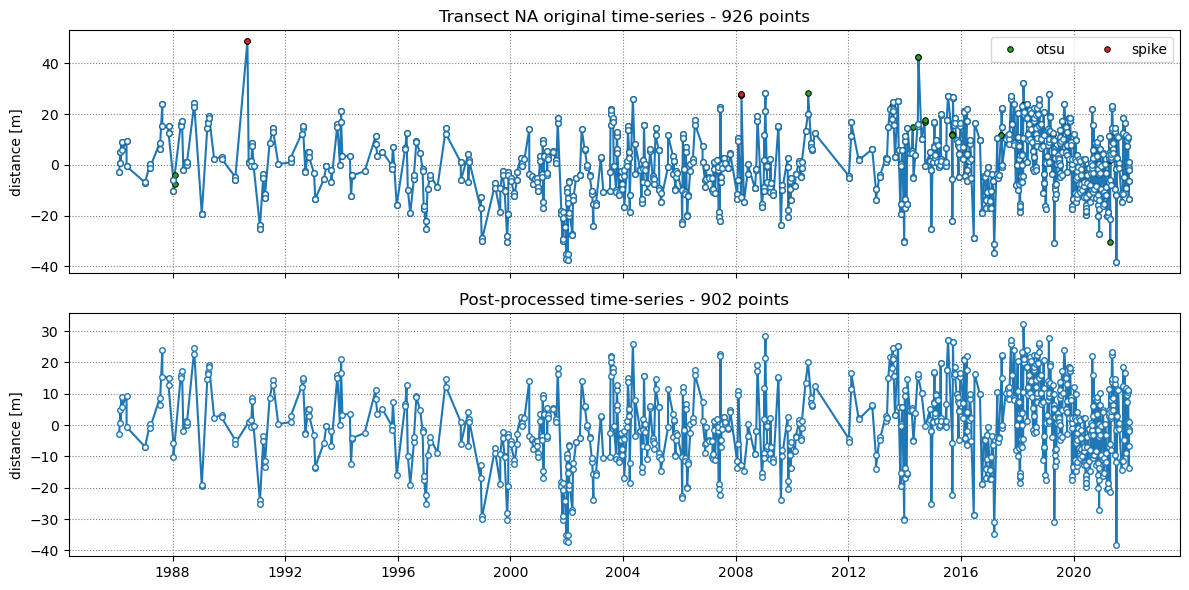

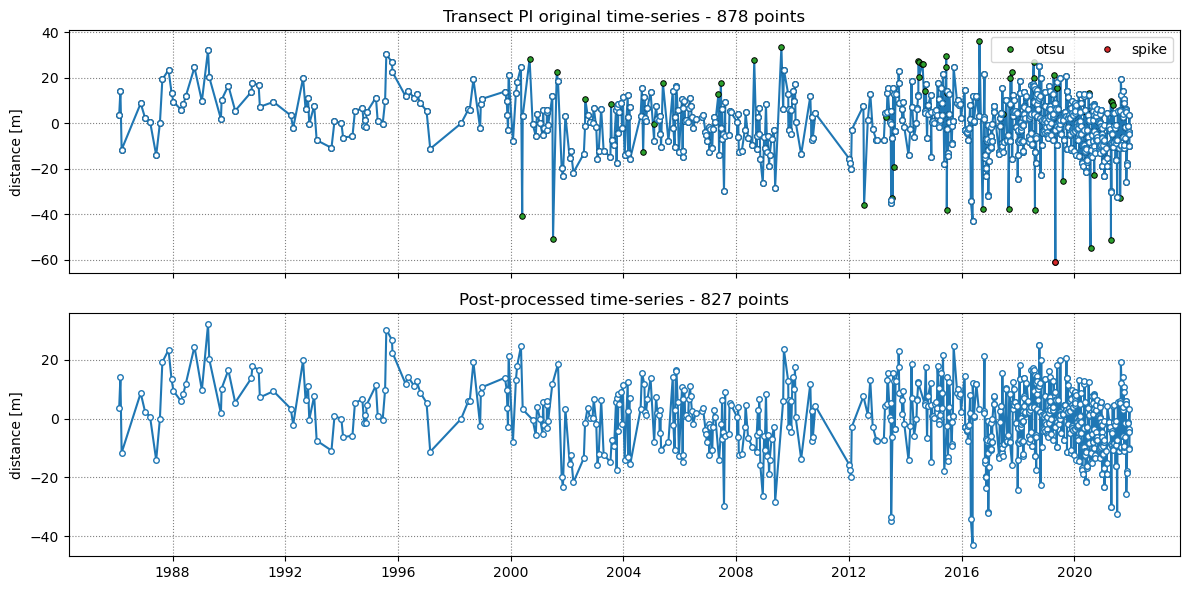

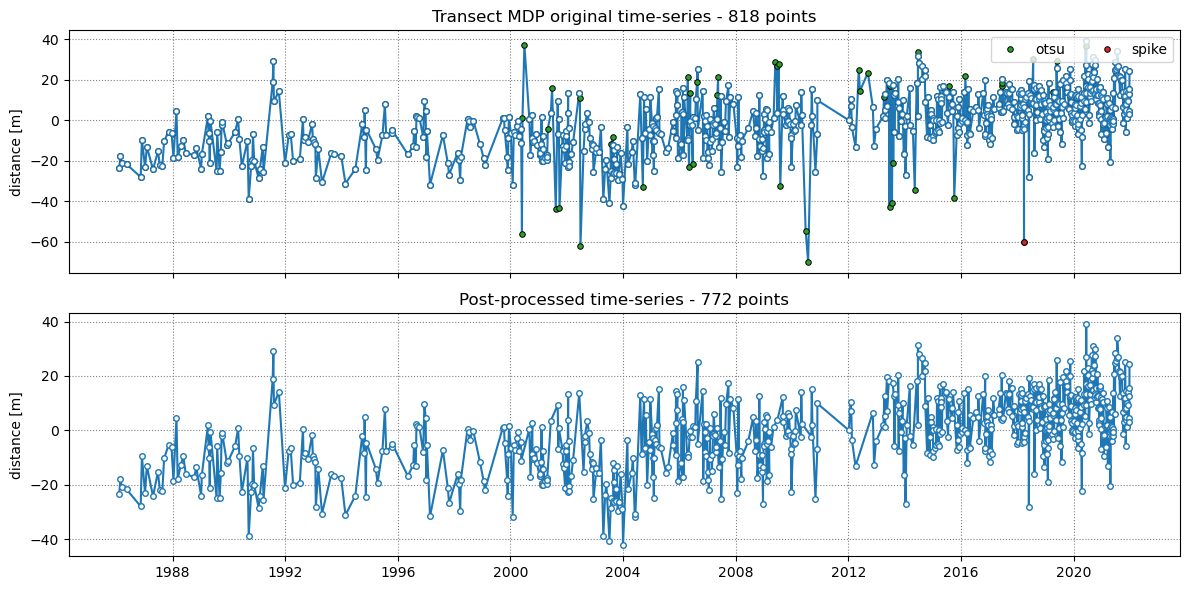

In [20]:
#remove outliers
cross_distance_final_msas_wave = {}    
    
for i, key in enumerate(transect_keys):
    cross_distance_msas = cross_distance_wave_corrected_msas[key]
    cross_distance_msas_dict = {transect_keys[i]: cross_distance_msas}
    output = output_all_filtered[key]
    
    cross_distance_final_msas1 = SDS_transects.reject_outliers( cross_distance_msas_dict, output, settings_outliers)
    cross_distance_final_msas_wave.update(cross_distance_final_msas1)

In [21]:
#Save bw data corrected
with open(os.path.join(dir_bw, 'cross_distance_tidally_corrected_msas_waves.pkl'), 'wb') as f:
    pickle.dump(cross_distance_final_msas_wave, f)

In [22]:
# Also save dates and satname information

In [23]:
with open(os.path.join(dir_bw,'dates.pkl'), 'wb') as f:
    pickle.dump(dates_sat, f)
    
with open(os.path.join(dir_bw,'satname.pkl'), 'wb') as f:
    pickle.dump(satname_all, f)